# Data Analysis Report

We first start off by understanding the different data we are provided, and take a look into the bits and pieces that we will need from the data and give things a bit more structure.

### Preface

Starting off the project, we were given large JSON files and a Python script to download said large files and work with. So, I had to think about how I would manipulate the data in a manner that would save time and not incurr huge processing/memory penalties. 

The first step was to deal with random metadata and arbitrary information within these files and strip them off to make life easier.

I would've done this in Python, but thankfully, the good folks at Riot gave us Athena Ready™ scripts that we can use to query (the significantly more) compressed data, directly from the S3 bucket without downloading files. 

So with the crawler setup and the tables loaded, I decided to sift through data within using SQL and AWS Athena explorer, and leveraged queries that reduced the data to the parts we are most interested in to create a methodology to generate team rankings.

The reduced data could then be downloaded as CSVs and read into Data Science tools for ease of use.

CSV is already quite good in terms of storage, but I've taken the liberty to convert certain large files from either JSON or CSV to [parquet](https://www.databricks.com/glossary/what-is-parquet) to save storage space.

## Leagues

The following SQL statement gives us a new leagues file with some of the redundant columns like `displayPriority`, `sport`, `image` etc. dropped

```sql
SELECT id, name, slug, region, tournaments FROM "lol"."leagues"
```

All in all, it seems that we have tournament data for 38 leagues hosted across the world.

In [188]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

leagues_df = pd.read_csv("../esports-data/leagues.csv")

In [2]:
leagues_df.head(5)

,id,name,slug,region,tournaments
0,98767991299243165,LCS,lcs,NORTH AMERICA,"[{id=110303581083678395}, {id=1095170900666056..."
1,109511549831443335,LCS Challengers,north_american_challenger_league,NORTH AMERICA,"[{id=110574243270525539}, {id=1095186976607462..."
2,109518549825754242,LCS Challengers Qualifiers,lcs_challengers_qualifiers,NORTH AMERICA,"[{id=110894544221659776}, {id=1107338389351362..."
3,107898214974993351,College Championship,college_championship,NORTH AMERICA,[{id=107898708099217418}]
4,98767991332355509,CBLOL,cblol-brazil,BRAZIL,"[{id=110413046183015975}, {id=1095236414167506..."


In [3]:
leagues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           38 non-null     int64 
 1   name         38 non-null     object
 2   slug         38 non-null     object
 3   region       38 non-null     object
 4   tournaments  38 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.6+ KB


#### All available leagues

In [53]:
league_name_df = pd.DataFrame({"name": leagues_df.name, "region": leagues_df.region}, columns=["name", "region"])
league_name_df.head()

,name,region
0,LCS,NORTH AMERICA
1,LCS Challengers,NORTH AMERICA
2,LCS Challengers Qualifiers,NORTH AMERICA
3,College Championship,NORTH AMERICA
4,CBLOL,BRAZIL


## Players & Teams

Looking into the players and teams data we notice that the players file has a `home_team_id` field for the player, while the teams data comes with `team_id` which this directly maps to.

### Problem 1: Improving and aggregating data

Originally the data was scattered, with `teams.json` and `players.json` being separate files.

The following query on Athena creates a mapping of every player to every team:

```sql
select distinct team_id as "teamId", name, acronym, slug, player_id as "playerId", handle, first_name, last_name
from lol."players" join lol."teams"
on team_id = home_team_id
```

We are not omitting anything here since we might want to leverage all the data here to build out some kind of nice front-end to deliver the results (time permitting). This created a CSV file which I downloaded and then converted to `parquet` for a smaller file footprint.

Obviously this mapped every player to a team, and that gives me 2618 entries. Not good, but we can handle everything else within pandas since Athena has given us everything we need to split things up!

In [13]:
teams_and_players_df = pd.read_parquet("../esports-data/distinct_team_player_mapping.parquet")
teams_and_players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2618 entries, 0 to 2617
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   team_id     2618 non-null   int64 
 1   name        2618 non-null   object
 2   acronym     2618 non-null   object
 3   slug        2618 non-null   object
 4   player_id   2618 non-null   int64 
 5   handle      2618 non-null   object
 6   first_name  2618 non-null   object
 7   last_name   2618 non-null   object
dtypes: int64(2), object(6)
memory usage: 163.8+ KB


In [14]:
print("Number of teams total: ", len(teams_and_players_df.name.unique()))
teams_and_players_df.head(5)

Number of teams total:  501


,team_id,name,acronym,slug,player_id,handle,first_name,last_name
0,105505619546859895,OKSavingsBank BRION,BRO,fredit-brion,99566404525897139,UmTi,Sunghyeon,Um
1,106827823550343961,AXZ Academy,AXZ,axz-academy,110536783764146522,kentakki,Kenta,Saito
2,98767991949608898,Fenerbahçe Espor,FB,fenerbahce-espor,99566404559755136,SeongHwan,Yun,Seong Hwan
3,109642680932009857,Nord Esports,NORD,nord-esports,110428375437150775,Hid0,Gian Miguel,Caruana
4,110534712174898632,Blue Otter,BOL,blue-otter,109800032657915058,Zev,Mark,Villaneuva


An immediate problem is posed since these aren't just mappings of the starting roster for the team to players, but also include subs and other members. For instance, Nukeduck is now a coach for 100T who was a former sub as a midlaner and is not part of the active roster in "playing" terms. 

So we need to keep this in mind before we proceed further and may have to leverage mapping data as source of truth for exact player information for those who "played" in the game vs players who are subs and coaches, if we are to extract game events for particular players to create a rating for the players themselves.

In [15]:
teams_with_more_than_5_players = teams_and_players_df.groupby('team_id').filter(lambda x: len(x) > 5)
print("Number of teams with more than 5 players: ", len(teams_with_more_than_5_players.name.unique()))
teams_with_more_than_5_players.sort_values(by=['name']).head(15)

Number of teams with more than 5 players:  230


,team_id,name,acronym,slug,player_id,handle,first_name,last_name
1325,99294153828264740,100 Thieves,100,100-thieves,98926509785257793,Ssumday,Chanho,Kim
59,99294153828264740,100 Thieves,100,100-thieves,99603798169593745,Closer,Can,Çelik
715,99294153828264740,100 Thieves,100,100-thieves,99322214616775017,Nukeduck,Erlend,Holm
2268,99294153828264740,100 Thieves,100,100-thieves,107569568015156338,Sniper,Rayan,Shoura
750,99294153828264740,100 Thieves,100,100-thieves,98767991769705572,Doublelift,Yiliang,Peng
451,99294153828264740,100 Thieves,100,100-thieves,107492071007218117,Quid,HYEONSEUNG,Lim
832,99294153828264740,100 Thieves,100,100-thieves,106625308523122120,Busio,Alan,Cwalina
2398,99294153828264740,100 Thieves,100,100-thieves,104559243245199489,Tenacity,Milan,Oleksij
738,109696138543579708,3BL Esports,3BL,ebl-esports,99682959194260565,Chosen,Yunus,Baş
2292,109696138543579708,3BL Esports,3BL,ebl-esports,109721399266584404,Meza,Hamza,El Barqoqi


But we are getting ahead of ourselves, let's first just do our due dilligence with the data to check for missing/duplicate values. We know that team_id will be duplicated due to the way the data is joined for each player. However, we really shouldn't be running into duplicate player values so let's check for that...

In [58]:
duplicate_players = teams_and_players_df[teams_and_players_df["player_id"].duplicated(keep=False)].sort_values("player_id")
duplicate_players

,team_id,name,acronym,slug,player_id,handle,first_name,last_name
357,101383793572656373,EXCEL,XL,excel,100174547541438669,Abbedagge,Felix2,Braun
2213,101383793572656373,EXCEL,XL,excel,100174547541438669,Abbedagge,Felix,Braun


We will get rid of the Abbedagge with the `Felix2` value since that's erroneous. Let's remove it and save a new copy of the cleaned data.

In [110]:
# remove 'Felix2'
team_player_mapping_cleaned = teams_and_players_df.drop(
    teams_and_players_df[(teams_and_players_df['handle'] == 'Abbedagge') & 
                        (teams_and_players_df['first_name'] == 'Felix2')].index)

# test
duplicate_players = team_player_mapping_cleaned[team_player_mapping_cleaned["player_id"].duplicated(keep=False)].sort_values("player_id")
duplicate_players

team_player_mapping_cleaned.rename(columns={'name': 'team_name'}, inplace=True)

# save the cleaned data UNCOMMENT
# cleaned_file_path = "../esports-data/cleaned_distinct_team_player_mapping.parquet"
team_player_mapping_cleaned.to_parquet(cleaned_file_path, index=False)

> From here on out, we should always be using cleaned_distinct_team_player_mapping.parquet or cleaned_distinct_team_player_mapping.csv 

***
## Mapping Data

Next, we need to look at the mapping data for the above since this is where things start to get interesting.

Here's the SQL to gather the info on Athena:

```sql
SELECT DISTINCT esportsgameid as "esports_game_id", platformgameid as "platform_game_id", teammapping as "team_mapping", participantmapping as "participant_mapping" FROM "lol"."mapping_data";
```

For this data, I decided to convert the JSON provided to parquet for a size reduction from 16.2MB to ~900KB. 

In [153]:
mapping_df = pd.read_parquet("../esports-data/mapping_data.parquet")

In [154]:
mapping_df.head(5)

,esportsGameId,platformGameId,teamMapping,participantMapping
0,110378429158160384,ESPORTSTMNT01:3416295,"{'100': '105550033967461806', '200': '10555002...","{'1': '108205130568869560', '10': '11073024065..."
1,110471139171602608,ESPORTSTMNT02:3228341,"{'100': '109485335453835911', '200': '10555000...","{'1': '103478281338008082', '10': '10539723866..."
2,110535609417029696,ESPORTSTMNT04:2693199,"{'100': '109696092218588987', '200': '10835230...","{'1': '109696535754261145', '10': '10756442829..."
3,110847390580148352,ESPORTSTMNT01:3413275,"{'100': '107700204561086446', '200': '99566406...","{'1': '99566406483827119', '10': '101383792831..."
4,110413246204026224,ESPORTSTMNT01:3412587,"{'100': '109485335453835911', '200': '10555000...","{'1': '103478281338008082', '10': '10374359384..."


In [155]:
mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25283 entries, 0 to 25282
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   esportsGameId       25283 non-null  int64 
 1   platformGameId      25283 non-null  object
 2   teamMapping         25283 non-null  object
 3   participantMapping  25283 non-null  object
dtypes: int64(1), object(3)
memory usage: 790.2+ KB


### Problem 1: Cleaning data

There's about 25,283 games, but there are a few key things we already want to start doing with this mapping data that maps to the `game` with respect to the teams.

First, we want to be able to identity games where information is complete. Our ML model would need as much data as possible and ensuring that we don't run into missing information is key to training and validating the model.

For starters, we want to turn those nested objects into a flatter structure such that we can start analyzing how much missing data we actually have, and how much of that can we fill

In [20]:
# Flatten the 'teamMapping' and 'participantMapping' columns
flattened_df = pd.concat([
    mapping_df.drop(['teamMapping', 'participantMapping'], axis=1),
    mapping_df['teamMapping'].apply(pd.Series),
    mapping_df['participantMapping'].apply(pd.Series).add_prefix('participant_')
], axis=1)

flattened_df.head()

,esportsGameId,platformGameId,100,200,participant_1,participant_10,participant_2,participant_3,participant_4,participant_5,participant_6,participant_7,participant_8,participant_9
0,110378429158160384,ESPORTSTMNT01:3416295,105550033967461806,105550026570060790,108205130568869560,110730240651882119,108366332471078988,107492116585043595,102483272156027229,105388980252039870,105501816646382923,106267599829820917,107492063150003806,106267600924403194
1,110471139171602608,ESPORTSTMNT02:3228341,109485335453835911,105550005698683818,103478281338008082,105397238669368241,103478281341350420,107560281476330464,101383793082615993,107559633217576287,105397207118950800,109519057410044019,103461966873003900,109519061710277829
2,110535609417029696,ESPORTSTMNT04:2693199,109696092218588987,108352305932141947,109696535754261145,107564428297402857,99566406317824602,105536902415377888,109696576870241602,109696579630268337,109705412728201213,105548731617719496,103963733877026827,105548605376090785
3,110847390580148352,ESPORTSTMNT01:3413275,107700204561086446,99566406332987990,99566406483827119,101383792831678607,99566406443271739,98767991808793901,107705431471339985,109642948838393879,100160799381721105,104668539132702977,105709404500072628,99566406296347493
4,110413246204026224,ESPORTSTMNT01:3412587,109485335453835911,105550001032913831,103478281338008082,103743593842085398,103478281341350420,107560281476330464,101383793082615993,107559633217576287,107559597273805278,110434822594728434,103980682928812378,108395451349202875


Now we can check for the missing values within this dataframe of flattened columns

In [21]:
# Check for missing values in the flattened DataFrame
missing_values_df = flattened_df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values_df[missing_values_df > 0]

columns_with_missing_values

100                 17
200                 19
participant_1      951
participant_10     990
participant_2      987
participant_3      935
participant_4     1008
participant_5      998
participant_6      933
participant_7      983
participant_8      935
participant_9     1008
dtype: int64

In [22]:
# Count the number of rows with any missing values
rows_with_missing_values = flattened_df.isnull().any(axis=1).sum()
rows_with_missing_values

1569

For now, let's just filter out rows with missing values since we might need to do additional data gathering to figure out which players are subs, and which are part of the playing roster within games. Dropping 1569 games for the time being is not an issue, so let's create another file which will contain our newly created dataframe as a parquet file.

In [33]:
# Filter out rows with any missing values
filtered_df = flattened_df.dropna(subset=["100", "200"] + [f"participant_{i}" for i in range(1, 11)])
len(filtered_df)

23714

Generating the filtered mapping data for our ease of use.

In [34]:
# UNCOMMENT BELOW TO SAVE OUTPUT AND BACKUP
# filtered_df.to_csv('../esports-data/filtered-mapping-data.csv', index=False)
# test_filtered_df = pd.read_csv('../esports-data/filtered-mapping-data.csv')
# len(test_filtered_df)

23714

> From here on, we should be using filtered-mapping-data.csv or filtered-mapping-data.parquet

## Tournaments Mapping

The tournaments mapping data is a bit convoluted since there's large nested objects within the `stages` column. We will need to break this down to see what's going on inside those objects...

This JSON data was 91.1MB and parquet takes it down to ~1.1MB.

Some caveats I've collected from various resource docs and discord answers (and questions to think about):
- Riot is only providing esports mappings and game data for LPL Summer 2023
    - Q: What methodology to use for determining rankings for past data where game data isn't available?
    - Need to analyze older games (relative to data) first and create estimates for what are the win conditions for a team based on available data
- Programs should be able to handle not finding an associated platform ID for a given esports ID
- In tournaments file, for each esports match listed there is a team field with players - these are the players listed for a given team roster at the time that the game was mapped and will also include subs - this does not mean all those players have played in the match
    - Need to check if player played in the game -> if role is none, it's a sub

### Problem 1: Reading nested data

For this, I wanted to get started on it since the instruction docs provided decent context on it already.
I wanted to get started by first sorting all the data by the `startDate`, since that would give us the older the time-frame from when any team has started playing games. 

In [38]:
tournaments_df = pd.read_parquet("../esports-data/tournaments.parquet")
tournaments_df.sort_values(by=["startDate"], inplace=True)
tournaments_df.head()

,id,leagueId,name,slug,sport,startDate,endDate,stages
243,103462439438682784,98767991299243168,LCS Spring 2020,lcs_spring_2020,lol,2020-01-24,2020-04-20,"[{'name': 'Regular Season', 'sections': [{'mat..."
83,103462459318635408,98767991302996016,LEC Spring 2020,lec_spring_2020,lol,2020-01-24,2020-04-27,"[{'name': 'Regular Season', 'sections': [{'mat..."
198,103462454280724880,99332500638116288,LCS Academy Spring 2020,lcs_academy_spring_2020,lol,2020-01-24,2020-04-20,"[{'name': 'Regular Season', 'sections': [{'mat..."
50,103478354329449184,98767991332355504,CBLOL 2020 Split 1,cblol_2020_split1,lol,2020-01-25,2020-05-03,"[{'name': 'Regular Season', 'sections': [{'mat..."
36,103535401218775280,98767991331560960,OPL 2020 Split 1,opl_2020_split1,lol,2020-01-31,2020-04-24,"[{'name': 'Regular Season', 'sections': [{'mat..."


In [39]:
print(f"We have access to {len(tournaments_df)} tournaments")

We have access to 248 tournaments


For the 248 tournaments, it's important to see how the nested `stages` structure looks. It's a complex nested structure, so we will need some elbow grease (nested for-loops) to start parsing out the relevant information we are looking for our algorithm to calculate team rankings.

The complex nesting makes this highly suitable for AWS Athena where a lot of this work is being cross-checked with SQL statements sprinkled in here and there, to ensure consistent outputs.

In [52]:
exploded_stages = tournaments_df['stages'].explode()
exploded_stages.head()

243    {'name': 'Regular Season', 'sections': [{'matc...
243    {'name': 'Playoffs', 'sections': [{'matches': ...
83     {'name': 'Regular Season', 'sections': [{'matc...
83     {'name': 'Playoffs', 'sections': [{'matches': ...
198    {'name': 'Regular Season', 'sections': [{'matc...
Name: stages, dtype: object

In [41]:
stage_names = set()
for i, v in enumerate(exploded_stages):
    stage_names.add(v['name'])

print(f"Num stage names: {len(stage_names)}")
stage_names

Num stage names: 18


{'Bracket Stage',
 'Groups',
 'Knockouts',
 'Play In Groups',
 'Play In Knockouts',
 'Playoffs',
 'Promotion Series',
 'Regional Finals',
 'Regional Qualifier',
 'Regular Season',
 'Round 1',
 'Round 2',
 'east',
 'knockouts',
 'play_in_knockouts',
 'promotion',
 'regional_qualifier',
 'west'}

In [77]:
games_list = []

for _, row in tournaments_df.iterrows():
    for stage in row['stages']:
        for section in stage.get('sections', []):
            for match in section.get('matches', []):
                for game in match.get('games', []):
                    if game.get('state') == "completed":
                        game_info = {
                            'id': game.get('id'),
                            'number': game.get('number'),
                            'state': game.get('state'),
                            'name': row.get('name'),
                            'slug': row.get('slug'),
                            'startDate': row.get('startDate'),
                            'endDate': row.get('endDate'),
                        }
                        for team in game.get('teams', []):
                            side = team.get('side')
                            outcome = team.get('result', {}).get('outcome')
                            game_info[f'team_{side}'] = team.get('id')
                            if outcome == 'win':
                                game_info['winner'] = side
                        games_list.append(game_info)

# create dataframe
games_df = pd.DataFrame(games_list)
games_df.rename(columns={'id': 'game_id'}, inplace=True)

print(f"We got {len(games_df)} completed games with a valid winner")

# games_df.to_csv("../esports-data/tournament-game-data.csv", index=False)
# games_df.to_parquet("../esports-data/tournament-game-data.parquet", index=False)
games_df.head()

We got 24628 completed games with a valid winner


,game_id,number,state,name,slug,startDate,endDate,team_blue,team_red,winner
0,103462440145619626,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98767991860392497,red
1,103462440145619628,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98767991877340524,red
2,103462440145619630,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98767991930907107,blue
3,103462440145619632,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,98926509883054987,103461966951059521,blue
4,103462440145619634,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98926509884398584,red


As we can see, from the mapping data, we had `25,283` total mappings out of which, `24628` of those actually consist of `completed` games with a provided winner outcome.

This is going to come in handy because when we want to start downloading actual game data, we can skip ones which don't mention the `completed` state and are more likely to have incomplete data. We can't afford to download every single game, so it's important to clean up the data and aggregate all the info that helps us make smarter choices further down the road.

We'll start downloading the game data and start analyzing further. I've updated the original script to help us concurrently download game data for the year we are interested in which can be found @ path "../utils/data-downloader.py"

> From here onwards, we should be using `tournament-game-data.parquet` or `tournament-game-data.csv`

# Features

## Features 1: Playing Side: Blue vs Red


Out of this file, the first bit of key information I am interested in is which team played on blue-side vs red-side. If you've played LoL at a high level, or watched pro-games, you'll come to know that based on the league meta, particular sides have their advantages.

For instance, in a patch where there's an OP champion that has no counters or is a top prio pick, blue team gets first draft and thus can instantly pick that champion for an advantage.

The sides should be given some weight also due to map layout differences.

**Blue team** has:
- an easier access to Baron, 
- top side gank paths (tri-brush)

**Red team** has:
- easier access to dragon
- bot side gank path (tri-brush). 

Historically, the top lane gank path for the **Blue side** has been more advantageous than the gank path for the bot side for **Red** due to the fact that top-lane only has **1 champion**.

There is no one else to help you ward, peel or escape from ganks if the blue team were to abuse this extra power while bot lane supports can at least peel or ward to prevent total abuse. To exemplify this, immobile top-lane champions on the red side have worse win-rates than on the blue-side:

![Immobile Red Blue Side Top Lane Comparison](doc-assets/red_blue_top.png)
![Red Blue Bot Lane Comparison](doc-assets/red_blue_bot.png)

Top lane could have close to ~5% win rate difference based on which side they are playing vs the ~1.5% difference of bot lane.

Plus, the advantages of blue side due to map layout are also within the domain of monster kills. While the Red side has an advantage to take dragon, there's a higher chance that an all out fight breaks out that can go either ways (TP from top lane, bot and mid rotates come in). However, a jungler might be able to sneak herald pre baron timer with minimal HP if the kiting is done well, which is to be expected at a pro-level.

Last but not least, there's also the aspect of the camera angle, of which the blue side can be referred as the "default" view since tutorials are done in this format, and also the angle creates a trapezium that provides some benefits for blue side viewing angles. 

This matter can seem subjective, but from my own anecdotal experience, playing on the red-side does take some getting used to and feels a little unnatural to throw skillshots down into the screen. At the highest level, this might not seem as significant, but that's why we won't just rely on the reference video, but will conduct an initial analysis on our dataset to come to our own conclusions.

Reference: https://www.youtube.com/watch?v=IOxhv9ipen8

### SubProblem 1: Games with unknown team IDs

#### Preface

> This part has been cleaned up after said data analysis to maintain flow of the project for any reader going in order, but the caveat is that a lot of this intuition came of cleaning and playing around with the data

So far, we've been heading in the right direction, and with our `tournament_game_data` and `cleaned_distinct_team_player_mapping` data, we can start looking into calculating blue and red win rates effectively. 


In [136]:
# load the cleaned distinct team player mapping file
team_player_mapping = pd.read_csv('../esports-data/cleaned_distinct_team_player_mapping.csv')

# load the tournament game data
tournament_game_data = pd.read_csv('../esports-data/tournament-game-data.csv')
team_player_mapping.head(), tournament_game_data.head()

(              team_id            team_name acronym              slug  \
 0  105505619546859895  OKSavingsBank BRION     BRO      fredit-brion   
 1  106827823550343961          AXZ Academy     AXZ       axz-academy   
 2   98767991949608898     Fenerbahçe Espor      FB  fenerbahce-espor   
 3  109642680932009857         Nord Esports    NORD      nord-esports   
 4  110534712174898632           Blue Otter     BOL        blue-otter   
 
             player_id     handle   first_name   last_name  
 0   99566404525897139       UmTi    Sunghyeon          Um  
 1  110536783764146522   kentakki        Kenta       Saito  
 2   99566404559755136  SeongHwan          Yun  Seong Hwan  
 3  110428375437150775       Hid0  Gian Miguel     Caruana  
 4  109800032657915058        Zev         Mark  Villaneuva  ,
               game_id  number      state             name             slug  \
 0  103462440145619626       1  completed  LCS Spring 2020  lcs_spring_2020   
 1  103462440145619628       1  com

In [162]:
# Calculate the number of games each team played on the blue side and the number of games they won on the blue side
blue_games = tournament_game_data.groupby('team_blue').size()
blue_wins = tournament_game_data[tournament_game_data['winner'] == 'blue'].groupby('team_blue').size()
blue_win_percentage = (blue_wins / blue_games * 100).fillna(0)

# Calculate the number of games each team played on the red side and the number of games they won on the red side
red_games = tournament_game_data.groupby('team_red').size()
red_wins = tournament_game_data[tournament_game_data['winner'] == 'red'].groupby('team_red').size()
red_win_percentage = (red_wins / red_games * 100).fillna(0)

# Merge the blue and red side win percentages into one DataFrame
win_percentages = pd.concat([blue_win_percentage, red_win_percentage], axis=1)
win_percentages.columns = ['Blue Side Win %', 'Red Side Win %']
win_percentages = win_percentages.fillna(0).reset_index()
win_percentages.columns = ['Team ID', 'Blue Side Win %', 'Red Side Win %']

# Create a mapping of team ID to team name
team_name_mapping = team_player_mapping.drop_duplicates(subset='team_id')[['team_id', 'team_name']].set_index('team_id')

# Merge the win percentages dataframe with the team name mapping
win_percentages_with_names = win_percentages.merge(team_name_mapping, left_on='Team ID', right_index=True, how='left')

win_percentages_with_names.head()

,Team ID,Blue Side Win %,Red Side Win %,team_name
0,98767991846127102,42.857143,70.833333,ahq eSports Club
1,98767991853197861,68.283582,61.885246,T1
2,98767991860392497,54.330709,44.094488,TSM
3,98767991866488695,54.198473,55.882353,Fnatic
4,98767991871709842,77.777778,55.555556,NaN


We can see that we have some NaN values for the team names that couldn't be mapped based on the data files, so let's fill those up with "Unknown" for the time being so we don't have to deal with NaN names.

In [163]:
# Fill any NaN team names with "Unknown"
win_percentages_with_names['team_name'] = win_percentages_with_names['team_name'].fillna('Unknown')
win_percentages_with_names = win_percentages_with_names[['Team ID', 'team_name', 'Blue Side Win %', 'Red Side Win %']]
win_percentages_with_names.head()

,Team ID,team_name,Blue Side Win %,Red Side Win %
0,98767991846127102,ahq eSports Club,42.857143,70.833333
1,98767991853197861,T1,68.283582,61.885246
2,98767991860392497,TSM,54.330709,44.094488
3,98767991866488695,Fnatic,54.198473,55.882353
4,98767991871709842,Unknown,77.777778,55.555556


Since we've had NaN/Unknown team names, it's implied that we have more team_id's than we have mappings. Let's quickly verify that from our cleaned data file.

In [172]:
# all unique team names and IDs from the cleaned_distinct_team_player_mapping dataset
unique_teams_mapping = team_player_mapping[['team_id', 'team_name']].drop_duplicates()
print(f"Number of unique teams provided in name mapping file: {len(unique_teams_mapping)}")

# number of team id's with blue/red side information
print(f"Number of teams with available win percentages: {len(win_percentages_with_names)}")

Number of unique teams provided in name mapping file: 502
Number of teams with available win percentages: 625


From the cleaned distinct team mapping data, we can see that the number of teams provided is 502, whereas we have 625 win-percentages. This presents us a new subproblem to tackle where we need to answer the following questions:
- how many of the teams present within the name mapping don't have games recorded within the tournaments file
- checks for any issues with the data before we derive statistical significance
- handling skews

We also have to perform a sanity check to ensure that we've not accidentally skipped valid mappings due to any errors on our part

***
### SubProblem 2: Knowns & Unknowns - verifying our actions thus far



In [174]:
# Count the number of entries where the team name is "Unknown"
unknown_teams = win_percentages_with_names[win_percentages_with_names['team_name'] == 'Unknown']

print(f"Number of team IDs with no name mapping (Unknown): {len(unknown_teams)}")

Number of team IDs with no name mapping (Unknown): 140


Woah! That's quite a bit of teams marked "Unknown". This raises further questions about the integrity of the data within these "Unknown" team rows. Do they have any actual % info in them? Did we mess up?

Let's try to answer that by checking which teams were omitted from the name info we do have access to.

In [173]:
missing_teams = unique_teams_mapping[~unique_teams_mapping['team_id'].isin(win_percentages_with_names['Team ID'])]
print(f"Missing teams from team-player data mapping: {len(missing_teams)}")
missing_teams

Missing teams from team-player data mapping: 17


,team_id,team_name
18,98926509887041994,Echo Fox
156,100285330169036485,Unsold Stuff Gaming
233,100205576949530558,Bursaspor Esports
638,99294153830557090,OpTic Gaming
651,99566404578577099,Jin Air Green Wings
854,99566405131343995,Echo Fox Academy
1382,98767991902391669,Flash Wolves
1383,102787200147504121,Campus Party Sparks
1402,99294153826603341,Clutch Gaming
1520,101157821459731619,Tandem Mode C


Since there's only 17 or so teams, I decided to do a brief manual check to verify my theory: 

> The primary reason for data for these teams not existing within our win-percentages file (which is derived from tournament data Riot provided), is because we genuinely don't have any data for these teams based on the leagues they play in, or the team is defunct and DNE anymore.

**Example 1:** The Spawn Esports is an active team that still plays today, but in the [Greek Legends Wings League](https://lol.fandom.com/wiki/GLWL/2022_Season/Spring_Season) which we have no data on.

Similarly, another reason we have no data for certain teams is because said team no longer exists!

**Example 2:** **OpTic Gaming** was [acquired by Immortals](https://venturebeat.com/business/immortals-esports-acquires-optic-gaming-owner-infinite-sports-entertainment/) in 2020 and last played at the [LCS 2019 Summer Playoffs](https://lol.fandom.com/wiki/OpTic_Gaming/Match_History), hence we have no data on them. 

> It is worth noting that we have win percentage info on Immortals AOE (107580444745581889) and Immortals Progressive (98767991930907107), with the latter being the main team after their [recent brand merger with Progressive Insurance](https://www.prnewswire.com/news-releases/immortals-and-progressive-insurance-announce-multi-year-league-of-legends-naming-rights-deal-301460064.html).

> [Immortals AOE](https://liquipedia.net/leagueoflegends/Immortals_AOE) is a defunct team which only played in the [LCS Proving Grounds leagues from 2021/2022](https://lol.fandom.com/wiki/Immortals_Area_of_Effect/Match_History), and hence we still have some data.

With all this said, the conclusion here is that we can safely ignore the potential of the lack of the mappings to erroneous operations on our end 😅 and move towards cleaning up the data to determine the statistical significance of blue/red side advantage.

### SubProblem 3: Cleaning data before analysis

With the mystery of missing mappings solved, now all that's left to be done is to finally clean up our data of all the factors that could potentially cause skews.

If a team, Unknown or Known, has only played on __one__ side and not the other, it can influence our analysis since we're comparing win percentages on both sides. 

Such teams could introduce bias, especially if they have extreme win percentages (very high like 100% or very low like 0%) on the one side they've played.

> NOTE: We can still keep the win percentages of Unknown teams since those are still games that we have data for from an environment which upholds a certain competitive integrity as deemed by Riot. Hence, despite the team name being unknown, they still add statistical significance for our purpose

Let's find out teams that have played on either blue or red side only.

In [178]:
# Identify teams that have played only on one side
only_blue = win_percentages_with_names[win_percentages_with_names['Red Side Win %'] == 0]
only_red = win_percentages_with_names[win_percentages_with_names['Blue Side Win %'] == 0]
print(f"Number of teams with only blue win %: {len(only_blue)}")
print(f"Number of teams with only red win %: {len(only_red)}")

Number of teams with only blue win %: 55
Number of teams with only red win %: 54


Given the numbers are this close (55/54), there's a high chance that a lot of this data is overlapping. 

Let's exclude them completely

In [185]:
exclusion_indices = only_blue.index.union(only_red.index)

# Exclude teams that have only played on one side
win_percentages_with_names_filtered = win_percentages_with_names.drop(exclusion_indices)
print(f"Filtered win-percentages with only red/blue removed: {len(win_percentages_with_names_filtered)}")

# win_percentages_with_names_filtered.to_csv("../esports-data/win-percentages-cleaned.csv", index=False)

Filtered win-percentages with only red/blue removed: 544


We are down to 544 from 625 we started off with. Now we are ready to dive into our win percentages to find statistical significance.

> From here on, use win-percentages-cleaned.csv

In [186]:
win_percentages_with_names_filtered.describe()

,Team ID,Blue Side Win %,Red Side Win %
count,5.440000e+02,544.000000,544.000000
mean,1.054890e+17,47.945943,45.318130
std,3.320169e+15,16.439803,16.087280
min,9.876799e+16,5.882353,5.263158
25%,1.035353e+17,36.363636,33.885267
50%,1.055940e+17,49.179446,46.153846
75%,1.075991e+17,59.003497,56.589052
max,1.107339e+17,100.000000,100.000000


Based on the descriptive statistics, on average, blue side wins ~2.63% more games.

Blue Side Win Percentage: Mean: 47.95%, Median: 49.18%, Standard Deviation: 16.44%

Red Side Win Percentage: Mean: 45.32%, Median: 46.15%, Standard Deviation: 16.09%
    
Let's plot this out for a clearer view

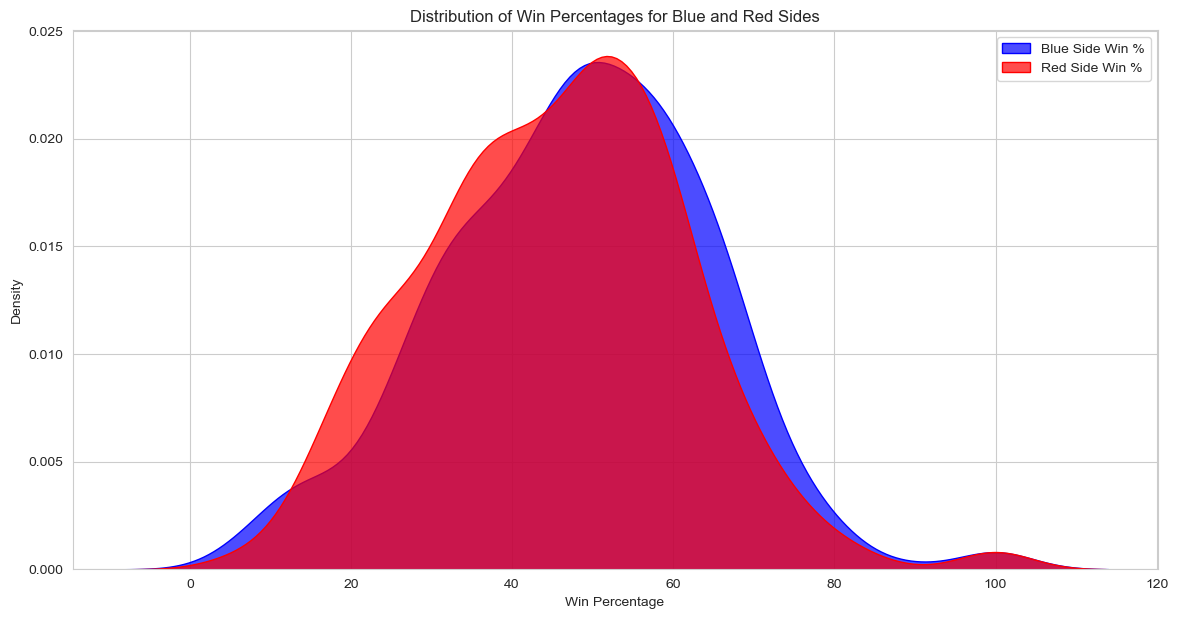

In [191]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))


sns.kdeplot(win_percentages_with_names_filtered['Blue Side Win %'], fill=True, color="blue", label="Blue Side Win %", alpha=0.7)
sns.kdeplot(win_percentages_with_names_filtered['Red Side Win %'], fill=True, color="red", label="Red Side Win %", alpha=0.7)

plt.title("Distribution of Win Percentages for Blue and Red Sides")
plt.xlabel("Win Percentage")
plt.ylabel("Density")
plt.legend()

plt.show()

The visualization provides a clearer view of the distributions of win percentages for both the blue and red sides. Here's what we can observe:
- both distributions appear somewhat normally distributed with some skewness.
- the blue side's distribution seems to have a slightly more pronounced peak around the 50% mark compared to the red side, supporting the observation from the descriptive statistics that the blue side has a slightly higher average win percentage.

In [193]:
# quick maffs
blue_favored = win_percentages_with_names_filtered[win_percentages_with_names_filtered['Blue Side Win %'] > win_percentages_with_names_filtered['Red Side Win %']].shape[0]
red_favored = win_percentages_with_names_filtered[win_percentages_with_names_filtered['Red Side Win %'] > win_percentages_with_names_filtered['Blue Side Win %']].shape[0]
equal_performance = win_percentages_with_names_filtered[win_percentages_with_names_filtered['Red Side Win %'] == win_percentages_with_names_filtered['Blue Side Win %']].shape[0]

blue_favored, red_favored, equal_performance

(320, 202, 22)

So roughly 320 teams have a higher win rate on blue, 202 have a higher rate on red, and around 22 teams have balanced 50% win rate on both sides.

We'll use a paired t-test since the data for blue and red sides come from the same teams. The null hypothesis will be that there is no difference in win percentages between the two sides, while the alternative hypothesis will be that there is a difference.

In [194]:
# Conduct a paired t-test
t_stat, p_value = ttest_rel(win_percentages_with_names_filtered['Blue Side Win %'], win_percentages_with_names_filtered['Red Side Win %'])

t_stat, p_value

(3.8686800345733583, 0.00012270991951739623)

The results of the paired t-test are as follows:
- t-statistic: 3.87
- p-value: 0.00012

Given a commonly used significance level of α=0.05, the p-value of 0.00012 is less than α. This means we can reject the null hypothesis and conclude that there is a statistically significant difference in the win percentages between the blue and red sides.

## Feature 2: First Tower %

TBD

In [195]:
print("TBD")

TBD


## Feature 3: First Blood %

TBD

## Feature 4: First baron %

TBD